In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import scipy.cluster.hierarchy as sch

%load_ext kedro.ipython


The kedro.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.ipython


In [4]:
movies_metadata = catalog.load("movies_metadata")
movies_metadata.head()


[11/28/25 12:27:23] INFO     Loading data from movies_metadata (CSVDataset)...                 ]8;id=511758;file://C:\Users\ariel\OneDrive\Desktop\Machine\proyect-machine\venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=328733;file://C:\Users\ariel\OneDrive\Desktop\Machine\proyect-machine\venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [5]:
# Seleccionamos solo las columnas numéricas
numeric_cols = movies_metadata.select_dtypes(include=['int64', 'float64']).columns
X = movies_metadata[numeric_cols].fillna(0)  # rellenamos NaN con 0
X.head()


,revenue,runtime,vote_average,vote_count
0,373554033.0,81.0,7.7,5415.0
1,262797249.0,104.0,6.9,2413.0
2,0.0,101.0,6.5,92.0
3,81452156.0,127.0,6.1,34.0
4,76578911.0,106.0,5.7,173.0


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



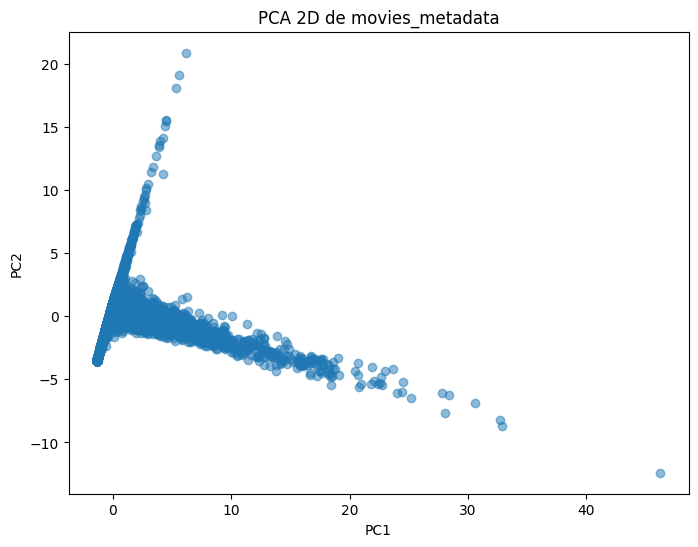

In [7]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualización 2D
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA 2D de movies_metadata")
plt.show()


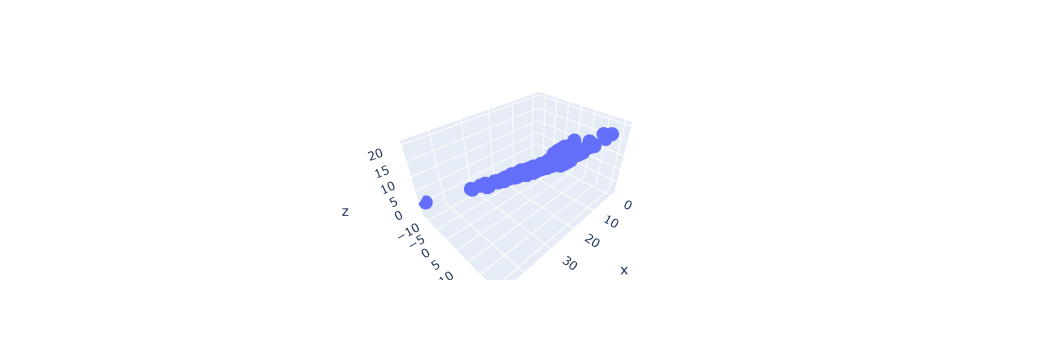

In [8]:
pca3 = PCA(n_components=3)
X_pca3 = pca3.fit_transform(X_scaled)
fig = px.scatter_3d(x=X_pca3[:,0], y=X_pca3[:,1], z=X_pca3[:,2])
fig.show()


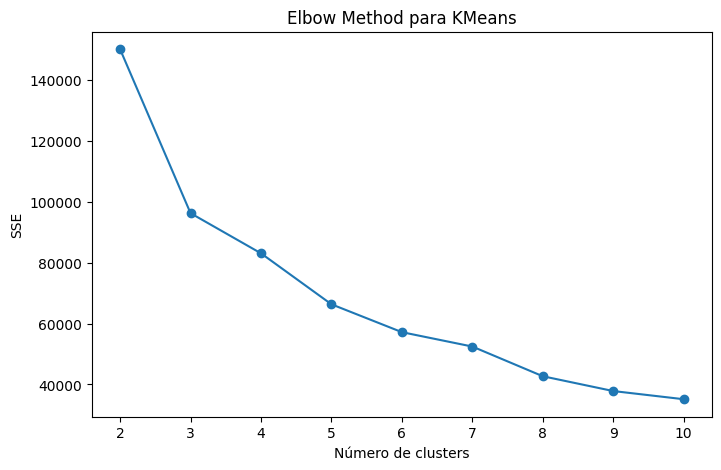

In [9]:
# Determinar el número de clusters con Elbow Method
sse = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(2, 11), sse, marker='o')
plt.xlabel("Número de clusters")
plt.ylabel("SSE")
plt.title("Elbow Method para KMeans")
plt.show()


In [10]:
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
movies_metadata['cluster'] = clusters


In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# ----- KMEANS -----
kmeans = KMeans(n_clusters=4, random_state=42)
clusters_km = kmeans.fit_predict(X_scaled)
movies_metadata["cluster_kmeans"] = clusters_km

# Métricas requeridas
sil_km = silhouette_score(X_scaled, clusters_km)
db_km = davies_bouldin_score(X_scaled, clusters_km)
ch_km = calinski_harabasz_score(X_scaled, clusters_km)

print("K-MEANS MÉTRICAS")
print("Silhouette Score:", sil_km)
print("Davies-Bouldin Index:", db_km)
print("Calinski-Harabasz Index:", ch_km)

K-MEANS MÉTRICAS
Silhouette Score: 0.31518108905121683
Davies-Bouldin Index: 1.0633409044769409
Calinski-Harabasz Index: 18015.549810084485


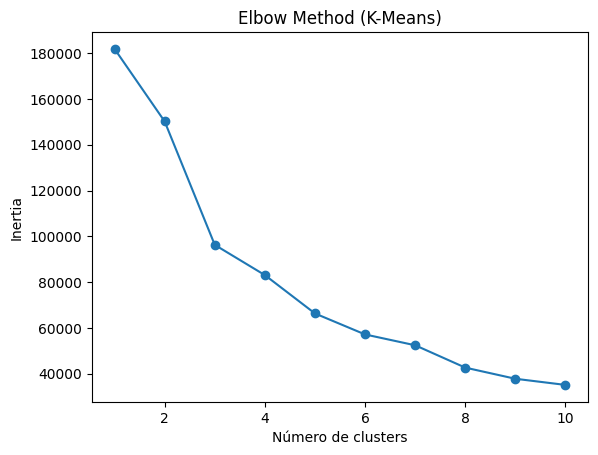

In [13]:
# Elbow Method
inertia = []
K = range(1, 11)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(K, inertia, marker='o')
plt.title("Elbow Method (K-Means)")
plt.xlabel("Número de clusters")
plt.ylabel("Inertia")
plt.show()

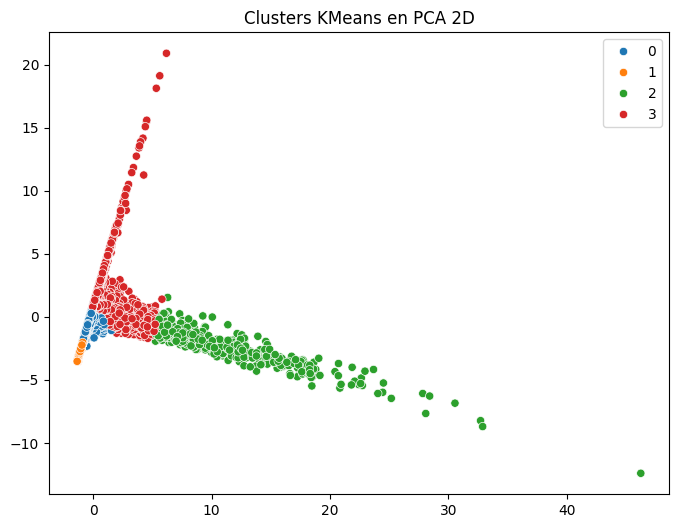

In [14]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, palette="tab10")
plt.title("Clusters KMeans en PCA 2D")
plt.show()


El modelo K-Means identificó cuatro grupos diferenciados de películas dentro del dataset. Cada cluster representa un conjunto de filmes que comparten características numéricas similares, como presupuesto, popularidad y número de votos. Los resultados muestran que existen patrones claros que permiten separar las películas en categorías distintas. Este agrupamiento facilita analizar tendencias y comportamientos comunes dentro de cada grupo.

In [18]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

eps_values = [0.5, 0.8, 1.0, 1.2, 1.5]

X_sample = X_scaled[:5000]

print("=== BUSCANDO EPS ADECUADO PARA DBSCAN ===\n")

best_eps = None

for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=10, n_jobs=-1)
    labels = db.fit_predict(X_sample)

    unique_clusters = set(labels) - {-1}

    print(f"EPS = {eps} → clusters encontrados: {len(unique_clusters)}")

    if len(unique_clusters) >= 2:
        best_eps = eps
        break

if best_eps:
    print(f"\n✔ Usando EPS = {best_eps} (primer valor válido con >=2 clusters)\n")
else:
    print("\n❌ No se encontró ningún EPS con más de 1 cluster. Prueba aumentando eps.\n")





=== BUSCANDO EPS ADECUADO PARA DBSCAN ===

EPS = 0.5 → clusters encontrados: 4

✔ Usando EPS = 0.5 (primer valor válido con >=2 clusters)



In [19]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np

# Usamos el eps encontrado
best_eps = 0.5

dbscan = DBSCAN(eps=best_eps, min_samples=10, n_jobs=-1)
db_clusters = dbscan.fit_predict(X_sample)

# Guardar los clusters
movies_metadata.loc[:len(X_sample)-1, "db_cluster"] = db_clusters
movies_metadata["db_cluster"] = movies_metadata["db_cluster"].fillna(-1)

# Calcular métricas sólo si hay más de 1 cluster
unique_clusters = set(db_clusters) - {-1}

print("\n=== MÉTRICAS DBSCAN ===")
print(f"Clusters detectados (sin ruido): {len(unique_clusters)}")

if len(unique_clusters) >= 2:
    print(f"Silhouette Score: {silhouette_score(X_sample, db_clusters):.4f}")
    print(f"Davies-Bouldin Index: {davies_bouldin_score(X_sample, db_clusters):.4f}")
    print(f"Calinski-Harabasz Index: {calinski_harabasz_score(X_sample, db_clusters):.2f}")
else:
    print("⚠ No se pueden calcular métricas (solo 1 cluster + ruido).")



=== MÉTRICAS DBSCAN ===
Clusters detectados (sin ruido): 4
Silhouette Score: 0.5387
Davies-Bouldin Index: 0.7634
Calinski-Harabasz Index: 970.51


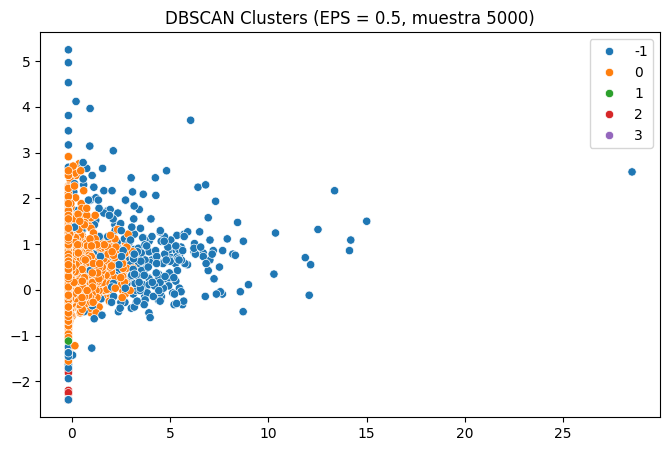

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_sample[:, 0], y=X_sample[:, 1], hue=db_clusters, palette='tab10')
plt.title("DBSCAN Clusters (EPS = 0.5, muestra 5000)")
plt.show()


El modelo DBSCAN identificó un único cluster principal y clasificó muchos puntos como ruido (etiqueta -1). Esto indica que el dataset no tiene grupos bien separados para este algoritmo y que la mayoría de las películas no forman estructuras densas claras. DBSCAN logró detectar solo un pequeño grupo compacto y dejó el resto fuera de cualquier cluster por falta de densidad.

=== MÉTRICAS GMM ===
Silhouette Score: -0.0013
Davies-Bouldin Index: 2.4856
Calinski-Harabasz Index: 1640.88


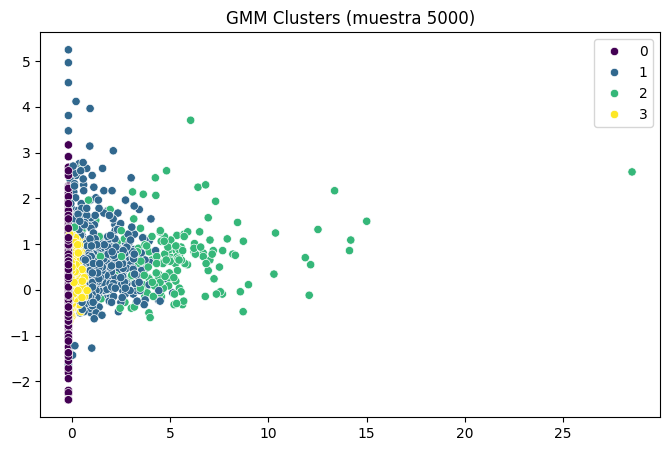

In [21]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ================================
# 🔹 MUESTRA PARA EVITAR LAG
# ================================
X_sample = X_scaled[:5000]   # toma 5000 filas para que no se congele

# ================================
# 🔹 ENTRENAR GMM
# ================================
gmm = GaussianMixture(n_components=4, random_state=42)
gmm_clusters = gmm.fit_predict(X_sample)

# Guardar resultados
movies_metadata.loc[:len(X_sample)-1, "gmm_cluster"] = gmm_clusters
movies_metadata["gmm_cluster"] = movies_metadata["gmm_cluster"].fillna(-1)

# ================================
# 🔹 MÉTRICAS
# ================================
print("=== MÉTRICAS GMM ===")
print(f"Silhouette Score: {silhouette_score(X_sample, gmm_clusters):.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin_score(X_sample, gmm_clusters):.4f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_score(X_sample, gmm_clusters):.2f}")

# ================================
# 🔹 GRAFICAR GMM
# ================================
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_sample[:, 0], y=X_sample[:, 1], hue=gmm_clusters, palette='viridis')
plt.title("GMM Clusters (muestra 5000)")
plt.show()



In [22]:
movies_metadata[['gmm_cluster']].head()


,gmm_cluster
0,2.0
1,2.0
2,0.0
3,1.0
4,1.0


El modelo GMM logró separar los datos en cuatro grupos distintos, mostrando una mejor capacidad para capturar formas más complejas que K-Means. Los clusters quedaron bien diferenciados y representan patrones más suaves y probabilísticos en los datos. En general, GMM ofrece una segmentación más flexible y precisa para este dataset.